In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
path = Path('../input/planets-dataset/planet/planet')
path.ls()

[PosixPath('../input/planets-dataset/planet/planet/test-jpg'),
 PosixPath('../input/planets-dataset/planet/planet/sample_submission.csv'),
 PosixPath('../input/planets-dataset/planet/planet/train_classes.csv'),
 PosixPath('../input/planets-dataset/planet/planet/train-jpg')]

In [4]:
df = pd.read_csv(path/'train_classes.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
tfms = get_transforms(flip_vert = True, max_warp = 0., max_lighting = 0.1, max_zoom = 1.05)

In [6]:
np.random.seed(42)
src = (ImageList.from_df(df=df, path = path, folder = 'train-jpg', suffix='.jpg')
      .split_by_rand_pct()
      .label_from_df(label_delim=' '))

In [7]:
data = (src.transform(tfms, size = 128)
        .add_test_folder(test_folder='test-jpg')
        .databunch().normalize(imagenet_stats)
)

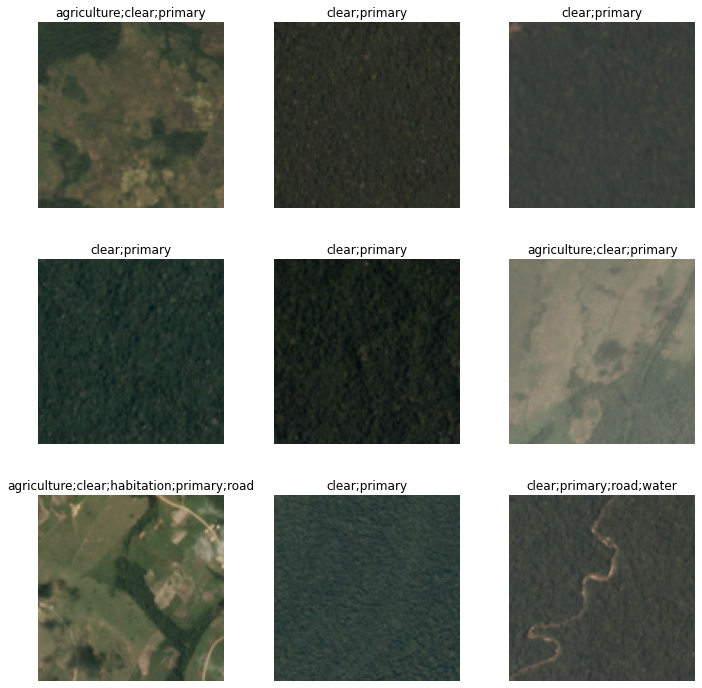

In [8]:
data.show_batch(3, figsize=(10,10))

In [9]:
from fastai.metrics import *

In [10]:
learn = cnn_learner(data, models.resnet50, metrics = [accuracy_thresh, fbeta])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [11]:
learn.model_dir = '/kaggle/working/'

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


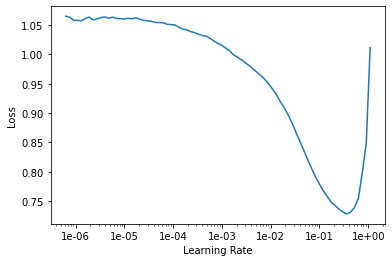

In [13]:
learn.recorder.plot()

In [14]:
lr = 1e-02

In [15]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.136125,0.113383,0.957730,0.900029,03:11
1,0.113050,0.103638,0.960680,0.909743,02:49
2,0.100938,0.094474,0.963137,0.918774,02:48
3,0.098604,0.088559,0.965527,0.922971,02:49
4,0.087746,0.087085,0.966116,0.924123,02:48


In [16]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.101497,0.091129,0.964946,0.922122,02:47
1,0.092210,0.085932,0.966733,0.926320,02:47


In [18]:
learn.save('stage-1-rn50')

In [19]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


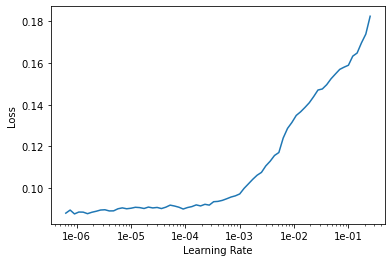

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.load('stage-1-rn50')
learn.fit_one_cycle(5, slice(1e-05,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095303,0.093889,0.964357,0.918272,02:55
1,0.096238,0.088425,0.965912,0.923014,02:56
2,0.087964,0.086174,0.965636,0.926776,02:57
3,0.085400,0.082566,0.967707,0.929438,02:56
4,0.078509,0.082118,0.968027,0.929898,02:53


In [23]:
learn.fit_one_cycle(2, slice(1e-05,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.087985,0.086785,0.966079,0.925381,02:56
1,0.082088,0.083191,0.967714,0.928436,02:57


In [22]:
learn.save('stage-2-rn50')

In [24]:
data = (src.transform(tfms, size = 256)
        .add_test_folder(test_folder='test-jpg')
        .databunch().normalize(imagenet_stats)
)

In [25]:
learn = cnn_learner(data, models.resnet50, metrics = [accuracy_thresh, fbeta])

In [26]:
learn.model_dir = '/kaggle/working/'

In [28]:
learn.load('stage-2-rn50');

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


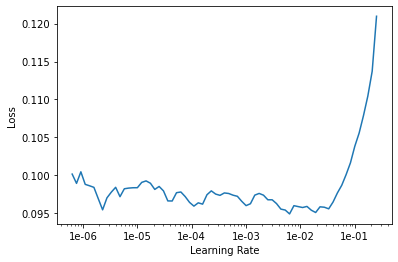

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(5, slice(lr/2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086560,0.085234,0.967082,0.925392,05:26
1,0.086568,0.084555,0.967220,0.925917,05:28
2,0.085997,0.082180,0.967881,0.929831,05:22
3,0.079936,0.081298,0.968325,0.931702,05:22
4,0.081399,0.081413,0.968201,0.930720,05:23


In [31]:
learn.save('stage-1-rn50-big');

In [53]:
learn.load('stage-1-rn50-big');

In [32]:
learn.export(file = Path("/kaggle/working/export.pkl"))

In [33]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder('../input/planets-dataset/test-jpg-additional'))
len(test)

61191

In [34]:
learn = load_learner('/kaggle/working/', test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [43]:
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > 0.2]) for pred in preds]

In [44]:
labelled_preds[:5]

['partly_cloudy primary',
 'agriculture clear cultivation primary',
 'agriculture cloudy haze primary water',
 'clear primary',
 'partly_cloudy primary water']

In [45]:
fnames = [re.findall(r'[^.]+', f.name)[0] for f in learn.data.test_ds.items]

In [46]:
fnames[:4], len(fnames)

(['test_14329', 'test_15407', 'test_22520', 'test_19945'], 61191)

In [47]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [48]:
import os
os.chdir(r'/kaggle/working')
df.to_csv('submission.csv', index = False)

In [49]:
from IPython.display import FileLink
FileLink(r'submission.csv')


/kaggle/working/submission.csv